I had some questions for the end of the notebook regarding what would typically done with testing out 6 different models like that. (Like, is there a good way to quickly eyeball comparisons?) I'm assumming that it wasn't intended for us to spend a long time trying to experiment with those models like we did for K-Means

# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

### Error Message
I think this error is just showing up because I dont have Microsoft office. I found the following cell of code on stackoverflow in case I need to use it

https://stackoverflow.com/questions/54976991/python-openpyxl-userwarning-unknown-extension-issue

In [2]:
#import warnings
#warnings.simplefilter("ignore")

In [3]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

C:\Users\alber\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


### 1b. Explore the data

In [4]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [5]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

C:\Users\alber\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


In [6]:
df_transactions.describe()

,offer_id,n
count,324.000000,324.0
mean,17.012346,1.0
std,9.703332,0.0
min,1.000000,1.0
25%,8.000000,1.0
50%,18.000000,1.0
75%,26.000000,1.0
max,32.000000,1.0


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

### Question, what does "read the documentation to develop your solution mean"?

In [7]:
#missing values function
def missing(df):
    '''Takes dataframe as argument, 
    returns count and % of missing values for each column'''
    import pandas as pd
    miss = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis = 1)
    miss.columns = ['count','%']
    return miss.sort_values(by = ['count'], ascending = False)

In [8]:
#your turn
#first check missing values

missing(df_transactions)

,count,%
customer_name,0,0.0
offer_id,0,0.0
n,0,0.0


In [9]:
missing(df_offers)

,count,%
offer_id,0,0.0
campaign,0,0.0
varietal,0,0.0
min_qty,0,0.0
discount,0,0.0
origin,0,0.0
past_peak,0,0.0


In [10]:
#double check
df_offers.isnull().values.any()

False

In [11]:
#double check
df_transactions.isnull().values.any()

False

Each row will represent a customer, and there will be one column with customer name, and columns for each offer with a 1 if customer responded (else 0). 

In [12]:
df_merged = df_transactions.merge(df_offers, how = 'left', on = 'offer_id')
df_merged.head()

,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak
0,Smith,2,1,January,Pinot Noir,72,17,France,False
1,Smith,24,1,September,Pinot Noir,6,34,Italy,False
2,Johnson,17,1,July,Pinot Noir,12,47,Germany,False
3,Johnson,24,1,September,Pinot Noir,6,34,Italy,False
4,Johnson,26,1,October,Pinot Noir,144,83,Australia,False


In [13]:
df_merged.dtypes

customer_name    object
offer_id          int64
n                 int64
campaign         object
varietal         object
min_qty           int64
discount          int64
origin           object
past_peak          bool
dtype: object

In [100]:
df = df_merged.pivot(index = 'customer_name', columns = 'offer_id', values = 'n')
df.tail(10)

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Turner,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN
Walker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Ward,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Watson,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
White,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Williams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
Wilson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Wood,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
Wright,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [15]:
df.fillna(0,inplace = True)
df.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [16]:
df1 = df.astype(int)
df1

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Williams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Wilson,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
Wood,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In general, having a smaller sum-of-squares error would represent better clusterings as they are tighter and would indicate clusters having members with more similarity. 

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.score

From scikit learn documentation, the attribute KMeans.inertia_ = SSE

In [17]:
# your turn
from sklearn.cluster import KMeans
import numpy as np

#np matrix x_cols
x_cols = np.array(df1)
X = np.array(df)

I wasn't sure if it would make a difference whether or not the values were floats or ints so I made 2 matrices to compare. (It didnt change the results, so I ended up using the array X, which had floats).

In [18]:
x_cols

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1]])

In [19]:
X

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.]])

In [20]:
X.shape

(100, 32)

Text(0.5, 1.0, 'Sum of Squares error vs # of clusters K')

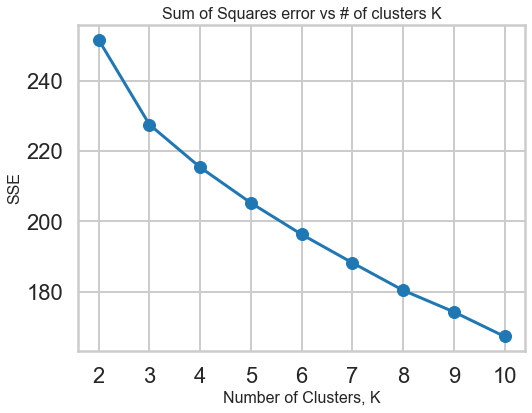

In [21]:
SSE = []
centers = [] 
counts=[]
Ks = range(2,11)
for k in Ks:
    model = KMeans(n_clusters = k, random_state = 123)
    model.fit(X)
    SSE.append(model.inertia_)
    centers.append(model.cluster_centers_)
    counts.append(model.labels_)
    

plt.figure(figsize=(8,6))
plt.plot(Ks, SSE , '-o')
plt.xlabel('Number of Clusters, K',fontsize = 16)
plt.ylabel('SSE',fontsize = 16)
plt.xticks(Ks)
plt.title('Sum of Squares error vs # of clusters K',fontsize = 16)



It changes depending on the random_state set, but here, it looks as if 3 is the most distinctive elbow point for k. Under other random_states, 8 and 9 also could have been a choice if a lower SSE was very important. Considering that we only have 100 data points though, at some point having a large k would seem to create clusters that are too specific.

For now we will say that k=3 is the best k.

<li>Make a bar chart showing the number of points in each cluster for k-means under the best  𝐾 .


In [22]:
from sklearn.cluster import KMeans
model3 = KMeans(n_clusters = 3, random_state = 123)

model3.fit(X)

KMeans(n_clusters=3, random_state=123)

In [23]:
labels = model3.labels_
labels

array([2, 0, 1, 2, 0, 0, 1, 2, 0, 2, 0, 1, 2, 0, 2, 1, 0, 1, 2, 0, 2, 2,
       0, 0, 1, 0, 0, 0, 0, 1, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2, 1, 1, 2, 0,
       2, 0, 2, 2, 0, 0, 0, 0, 0, 1, 0, 2, 1, 2, 2, 0, 0, 2, 0, 2, 2, 1,
       1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 1, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 0,
       0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0])

In [24]:
#checking to see if labels_ attribute is same as fit_predict method
test = model3.fit_predict(X)
test

array([2, 0, 1, 2, 0, 0, 1, 2, 0, 2, 0, 1, 2, 0, 2, 1, 0, 1, 2, 0, 2, 2,
       0, 0, 1, 0, 0, 0, 0, 1, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2, 1, 1, 2, 0,
       2, 0, 2, 2, 0, 0, 0, 0, 0, 1, 0, 2, 1, 2, 2, 0, 0, 2, 0, 2, 2, 1,
       1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 1, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 0,
       0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0])

The KMeans labels_ attribute suffices to get the results you would get from calling the fit_predict() method

In [25]:
model3.inertia_

227.62500000000006

In [26]:
#to show inertia_ is SSE
labels = model3.labels_
centers = model3.cluster_centers_
ss = np.sum((x_cols - centers[labels]) ** 2)
ss

227.625

In [27]:
counts = []
for i in range(3):
    counts.append((labels == i).sum())
counts    

[48, 16, 36]

Text(0, 0.5, 'Number of points')

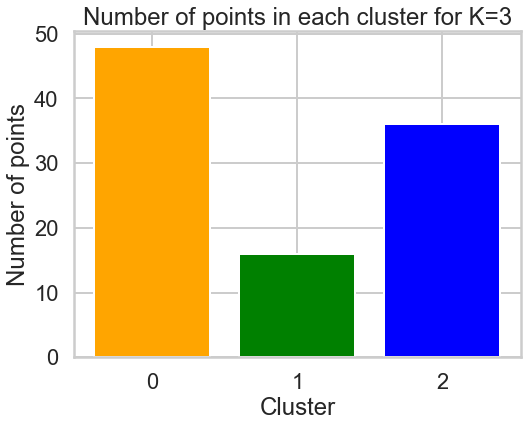

In [28]:
plt.figure(figsize=(8,6))
plt.bar(range(3), counts, color = ['orange','green','blue'])
plt.title('Number of points in each cluster for K=3')
plt.xlabel('Cluster')
plt.ylabel('Number of points')



#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

The article mentioned had a dead link but I was able to find the following code in the Tier 1 notebook (which came from sklearn documentation). I only made a few minor changes (defining Krange, changing font sizes etc). 

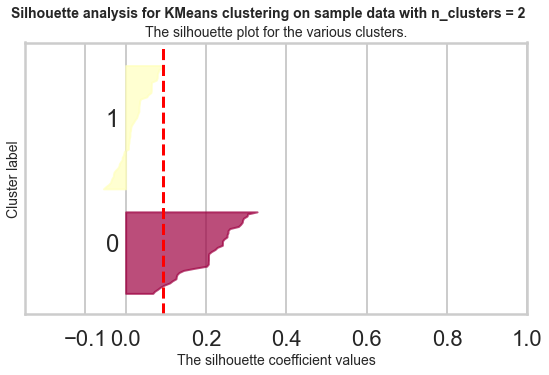

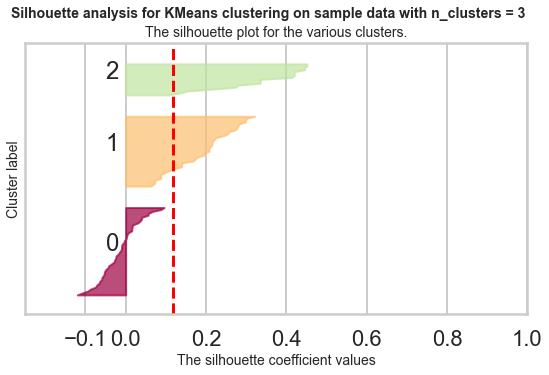

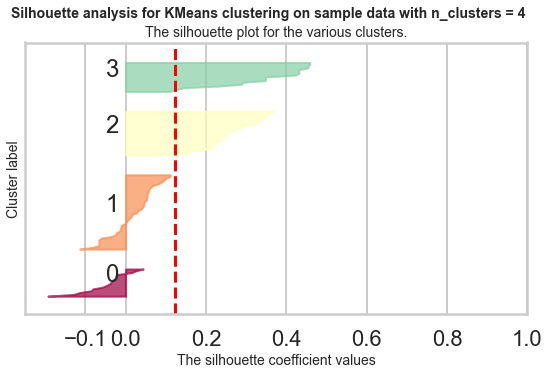

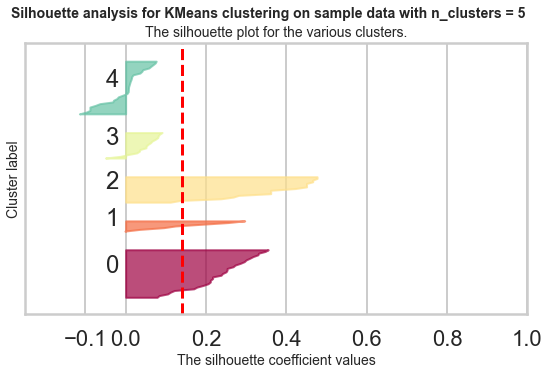

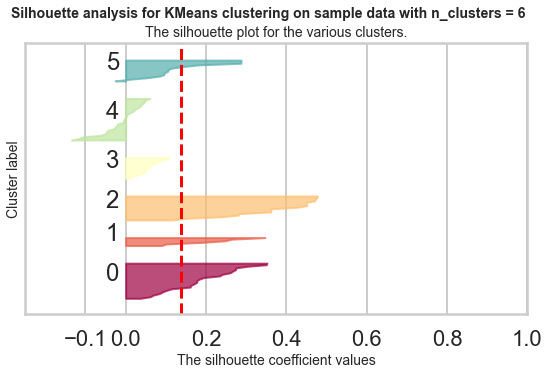

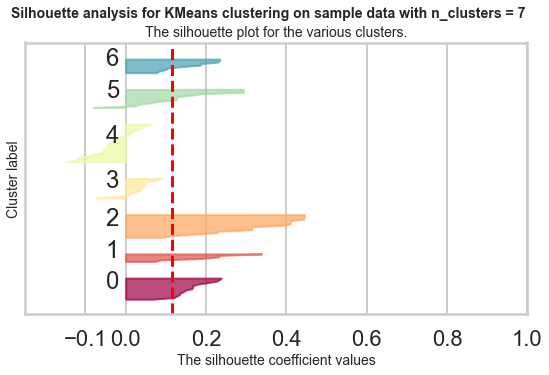

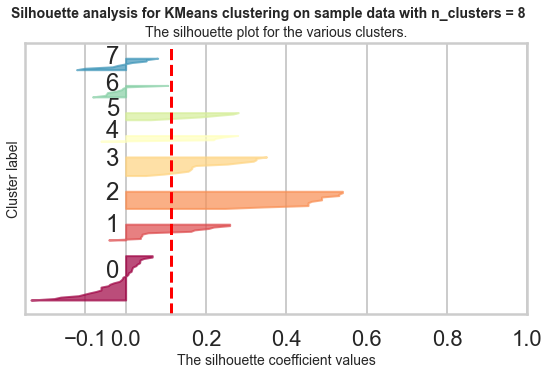

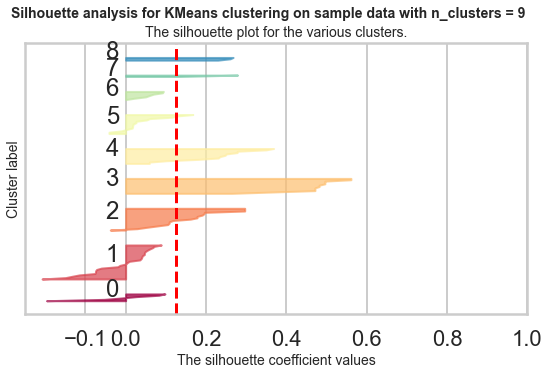

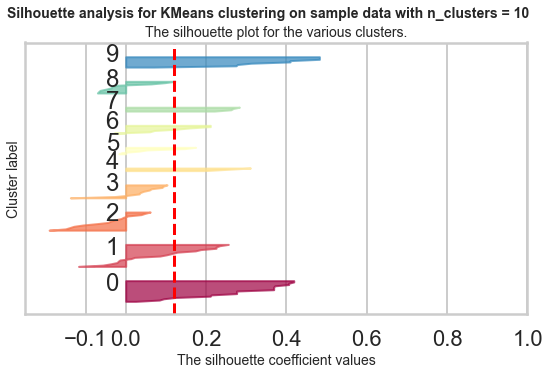

In [29]:
# This is an exercise in adapting someone else's code for our own use; a very common practice for data scientists and programmers alike
# OUR SOURCE: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

import sklearn.metrics
import matplotlib.cm as cm

# Make an empty list called avg_silhouette_scores
avg_silhouette_scores = []
Krange = list(range(2,11))
# Iterate through Krange with variable K as before
for K in Krange:
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(9, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    # Call set_xlim on ax1 
    ax1.set_xlim([-0.25, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (K + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = sklearn.cluster.KMeans(n_clusters=K, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    # Make a variable called silhouette_avg. Set the parameters to silhouette_score to X, and cluster_labels
    silhouette_avg  = sklearn.metrics.silhouette_score(X, cluster_labels)
    avg_silhouette_scores.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    # Call sklearn.metrics.silhouette_samples with the below parameters
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(K):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        # Make a variable called ith_cluster_silhouette_values
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        # Call sort() on this variable 
        ith_cluster_silhouette_values.sort()
    
        # Call shape[0] on ith_cluster_silhouette_values 
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / K)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        # This requires calling text() on ax1 
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    # Setting title, xlabel and ylabel 
    plt.title("The silhouette plot for the various clusters.", fontsize = 14)
    plt.xlabel("The silhouette coefficient values", fontsize = 14)
    plt.ylabel("Cluster label", fontsize = 14)

    # The vertical line for average silhouette score of all the values
    # This requires axvline() 
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % K),
                 fontsize=14, fontweight='bold')

In [30]:
# Your turn.
from sklearn.metrics import silhouette_score
silhouette_score(x_cols, labels)

0.12101628521627421

Text(0.5, 1.0, 'Average Silhouette score vs # of clusters K')

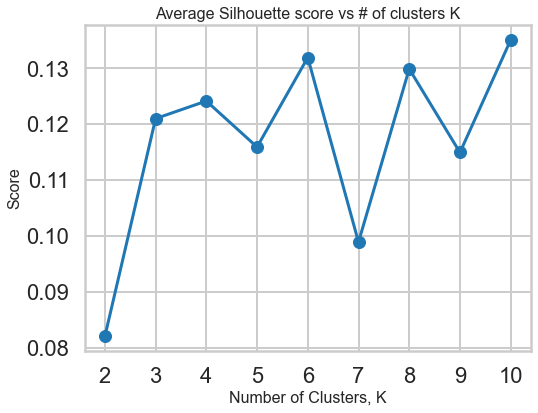

In [31]:
sil_scores = []
Ks = range(2,11)
for k in Ks:
    model = KMeans(n_clusters = k, random_state = 123)
    model.fit(X)
    sil = silhouette_score(X, model.labels_)
    sil_scores.append(sil)
    
    

plt.figure(figsize=(8,6))
plt.plot(Ks, sil_scores, '-o')
plt.xlabel('Number of Clusters, K',fontsize = 16)
plt.ylabel('Score',fontsize = 16)
plt.xticks(Ks)
plt.title('Average Silhouette score vs # of clusters K',fontsize = 16)



All of the average sillhouette scores are relatively low ($ < 0.25$), so once again it is hard to choose the best K. After K = 3, there are slightly better scores at K = 4,6,7,10.

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

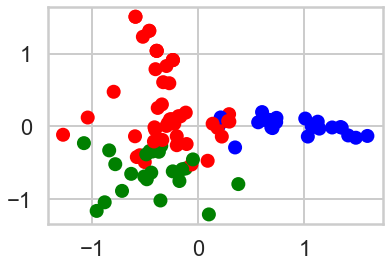

In [32]:
import sklearn.decomposition
import matplotlib.colors

# Make a variable called model. We want n_clusters = 3 as parameter to sklearn.cluster.KMeans 
model = sklearn.cluster.KMeans(n_clusters=3)
# Call a fit_predict() on X 
cluster_assignments = model.fit_predict(X)

# Let's visualiaze with colors.ListedColormap
cmap = matplotlib.colors.ListedColormap(['red', 'green', 'blue'])

# We're going to do some PCA here. Call decomposition.PCA on sklearn, and pass n_components=2 as parameter
pca = sklearn.decomposition.PCA(n_components=2)
pc1, pc2 = zip(*pca.fit_transform(X))
plt.scatter(pc1, pc2, c=cluster_assignments.tolist(), cmap=cmap)

In [33]:
pivoted = df

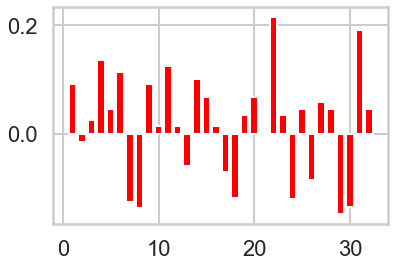

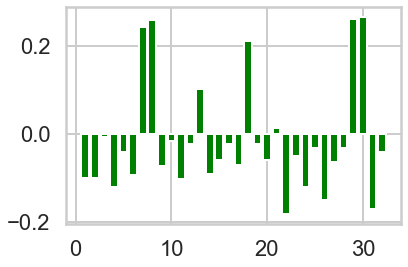

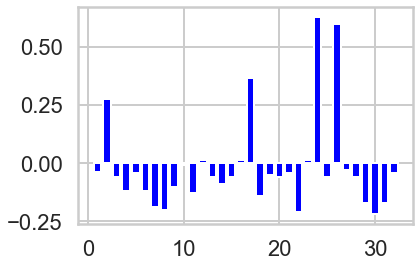

In [34]:
# Plot count of offer_id in each cluster.
# But, certain offers were used more than others in the original data.
# Let's compute the difference between how often they were used in each cluster vs globally.
model = sklearn.cluster.KMeans(n_clusters=3)
cluster_assignments = model.fit_predict(X)

colors = ['red', 'green', 'blue']
offer_proportions = pivoted.sum(axis=0) / 100  # There are 100 customers
for i in range(3):
    plt.figure(i)
    cluster = pivoted[cluster_assignments == i]
    offer_proportions_cluster = cluster.sum(axis=0) / cluster.shape[0]  # Number of customers in cluster
    lift = offer_proportions_cluster - offer_proportions
    plt.bar(range(1, 33), lift, color=colors[i])

In [35]:
df

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Williams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Wilson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Wood,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [41]:
X.shape


(100, 32)

In [42]:
X

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.]])

In [43]:
#take the transpose so PCA works on the right axis
Xt = X.T
Xt.shape

(32, 100)

In [44]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2, random_state = 123)
pca.fit(Xt)

PCA(n_components=2, random_state=123)

In [45]:
pca.components_.shape

(2, 100)

In [46]:
comp = pca.components_

In [47]:
#same as model.labels_
cluster_assignments = model3.fit_predict(X)
type(cluster_assignments)

numpy.ndarray

In [48]:
names = list(df.index)

In [49]:
dfPCA = pd.DataFrame([names, model3.labels_]).transpose()
#dfPCA

In [50]:
dfPCA['x'] = comp[0]
dfPCA['y'] = comp[1]

In [51]:
dfPCA

,0,1,x,y
0,Adams,2,0.177320,-0.036973
1,Allen,0,-0.030010,0.018504
2,Anderson,1,-0.050420,-0.158756
3,Bailey,2,0.131957,0.003854
4,Baker,0,0.043677,0.092959
...,...,...,...,...
95,Williams,0,0.019314,0.135760
96,Wilson,2,0.130966,0.006005
97,Wood,0,-0.051635,0.093716
98,Wright,0,-0.049473,0.086418


This plot shows the x and y values of the 2 PCA components, with the color representing what cluster the point associated with those values was assigned to

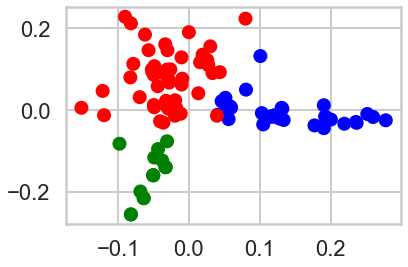

In [52]:
import matplotlib.colors
cmap = matplotlib.colors.ListedColormap(['red', 'green', 'blue'])

plt.scatter(dfPCA['x'], dfPCA['y'], c = list(cluster_assignments), cmap = cmap)

## Here I am doing clustering using just the PCA components

Now I will try to get cluster assignments using the PCA components instead of original 32 features

In [53]:
compT = comp.T
modelPCA = KMeans(n_clusters = 3)
modelPCA.fit(compT)

KMeans(n_clusters=3)

Text(0.5, 1.0, 'Sum of Squares error vs # of clusters K')

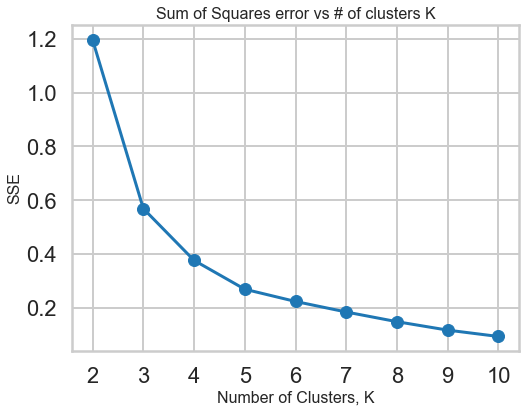

In [54]:
SSE_pca = []
centers_pca = [] 
counts_pca =[]
Ks = range(2,11)

for k in Ks:
    model = KMeans(n_clusters = k, random_state = 123)
    model.fit(compT)
    SSE_pca.append(model.inertia_)
    centers_pca.append(model.cluster_centers_)
    counts_pca.append(model.labels_)
    

plt.figure(figsize=(8,6))
plt.plot(Ks, SSE_pca , '-o')
plt.xlabel('Number of Clusters, K',fontsize = 16)
plt.ylabel('SSE',fontsize = 16)
plt.xticks(Ks)
plt.title('Sum of Squares error vs # of clusters K',fontsize = 16)



What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

In [55]:
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X)
ev = pca.explained_variance_

In [77]:
ev

array([0.4096489 , 0.30753551, 0.2022926 , 0.16703717, 0.15015248,
       0.1434373 , 0.13818887, 0.12192294, 0.11636172, 0.10804271,
       0.09937813, 0.09495961, 0.08690352, 0.07256738, 0.0660996 ,
       0.06245473, 0.05634388, 0.05327395, 0.04728801, 0.04393911,
       0.03900424, 0.03625783, 0.03455714, 0.03235091, 0.02940632,
       0.02618221, 0.02308167, 0.02142632, 0.018814  , 0.0165252 ,
       0.01426187, 0.0077789 ])

Text(0, 0.5, 'Proportion of Variance Explained')

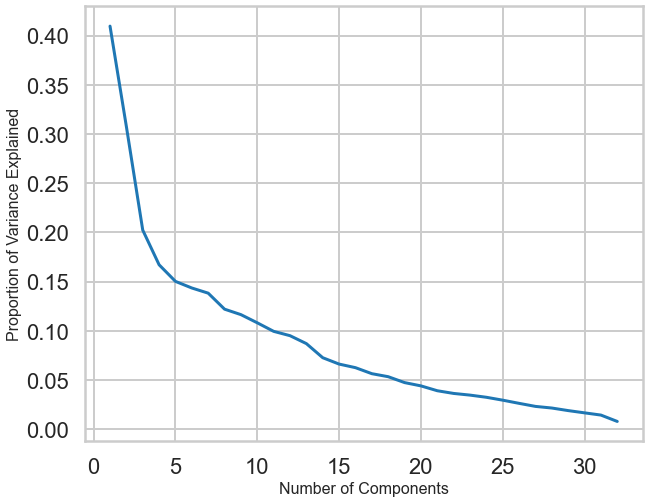

In [81]:
plt.figure(figsize=(10,8))

compnum = list(range(1,33))
plt.plot(compnum, ev)
plt.xlabel("Number of Components", fontsize = 16)
plt.title("Variance explained by PCA component (all 33)")
plt.ylabel("Proportion of Variance Explained", fontsize = 16)



For easier viewing, lets only look at the first 10 components

In [78]:
ev10 = ev[:10]

Text(0, 0.5, 'Proportion of Variance Explained')

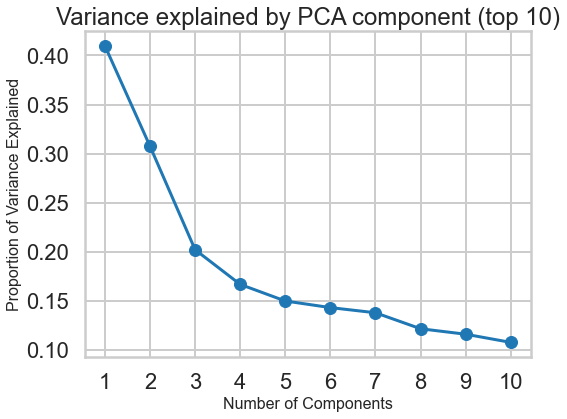

In [87]:
plt.figure(figsize=(8,6))

compnum10 = list(range(1,11))
plt.plot(compnum10, ev10,'-o')
plt.xlabel("Number of Components", fontsize = 16)
plt.title("Variance explained by PCA component (top 10)")
plt.xticks(compnum10)
plt.ylabel("Proportion of Variance Explained", fontsize = 16)



From this, it looks like the optimal number of dimensions is 3 (an argument could be made for 4 or 5 as well)

## 4. Conclusions and next steps

What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

It seems like the best choice for the number of clusters is 3. One interesting reoccuring theme was that several of the metrics seemed to indicate that this was not the best approach for this given set of data. (High SSE's, low sillhouette scores). 

Something else I was curious about was how to apply the knowledge optained from the PCA. If it had suggested a different dimension, would it now be a good idea to try to fit another model in which we would set the K a-priori?

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [59]:
#should maybe add to begining of the nb
def sse_fct(m, data, k = None):
    '''
    Function to plot the sum of squares error for a range of k values (if k is parameter)
    '''
    
    SSE_pca = []
    centers_pca = [] 
    counts_pca =[]
    Ks = range(2,11)

    for k in Ks:
        model = m(n_clusters = k, random_state = 123)
        model.fit(data)
        #SSE_pca.append(model.inertia_)
        centers_pca.append(model.cluster_centers_)
        counts_pca.append(model.labels_)


    plt.figure(figsize=(8,6))
    plt.plot(Ks, SSE_pca , '-o')
    plt.xlabel('Number of Clusters, K',fontsize = 16)
    plt.ylabel('SSE',fontsize = 16)
    plt.xticks(Ks)
    plt.title('Sum of Squares error vs # of clusters K',fontsize = 16)


In [60]:
from sklearn.cluster import AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN

In [93]:
modelAP = AffinityPropagation(random_state = 123)
modelSC = SpectralClustering(random_state = 123)
modelAggC = AgglomerativeClustering()
modelDBSCAN = DBSCAN(eps = 1.0)

In [62]:
modelAP.fit(X)
modelAP.cluster_centers_.shape

(14, 32)

Affinity Propagation suggests 14 clusters (running with all parameters except random_state as default)

In [63]:
modelAP.affinity_matrix_

array([[-0., -5., -5., ..., -7., -7., -9.],
       [-5., -0., -4., ..., -6., -4., -6.],
       [-5., -4., -0., ..., -6., -6., -8.],
       ...,
       [-7., -6., -6., ..., -0., -8., -8.],
       [-7., -4., -6., ..., -8., -0., -8.],
       [-9., -6., -8., ..., -8., -8., -0.]])

In [64]:
modelSC.fit(X)

SpectralClustering(random_state=123)

In [65]:
modelSC.affinity_matrix_

array([[1.00000000e+00, 6.73794700e-03, 6.73794700e-03, ...,
        9.11881966e-04, 9.11881966e-04, 1.23409804e-04],
       [6.73794700e-03, 1.00000000e+00, 1.83156389e-02, ...,
        2.47875218e-03, 1.83156389e-02, 2.47875218e-03],
       [6.73794700e-03, 1.83156389e-02, 1.00000000e+00, ...,
        2.47875218e-03, 2.47875218e-03, 3.35462628e-04],
       ...,
       [9.11881966e-04, 2.47875218e-03, 2.47875218e-03, ...,
        1.00000000e+00, 3.35462628e-04, 3.35462628e-04],
       [9.11881966e-04, 1.83156389e-02, 2.47875218e-03, ...,
        3.35462628e-04, 1.00000000e+00, 3.35462628e-04],
       [1.23409804e-04, 2.47875218e-03, 3.35462628e-04, ...,
        3.35462628e-04, 3.35462628e-04, 1.00000000e+00]])

In [66]:
SClabels = modelSC.labels_
SClabels

array([3, 4, 1, 6, 4, 4, 1, 1, 0, 6, 0, 1, 6, 4, 1, 1, 4, 1, 6, 0, 6, 1,
       5, 0, 7, 4, 4, 4, 4, 1, 6, 3, 0, 2, 6, 3, 0, 6, 0, 3, 1, 7, 1, 4,
       6, 2, 6, 6, 4, 0, 0, 4, 1, 7, 5, 1, 7, 6, 3, 1, 4, 1, 4, 3, 3, 1,
       7, 4, 0, 4, 4, 4, 5, 6, 4, 6, 1, 5, 3, 1, 4, 4, 4, 1, 6, 3, 6, 4,
       4, 1, 2, 3, 4, 6, 0, 4, 1, 4, 2, 4])

In [67]:
np.max(SClabels)

7

Spectral Clustering suggests 8 clusters

In [68]:
modelAggC.fit(X)

AgglomerativeClustering()

In [69]:
modelAggC.n_clusters_

2

Agglomerative clustering suggests 2

In [99]:
#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
modelDBSCAN.fit(X)

DBSCAN(eps=1.0)

In [95]:
modelDBSCAN.labels_

array([ 0, -1,  1,  2, -1, -1,  1,  2, -1,  2, -1,  1,  2, -1, -1,  1, -1,
        1,  0, -1,  2,  2, -1, -1,  1, -1, -1, -1, -1, -1,  3, -1, -1, -1,
       -1, -1, -1,  2, -1, -1,  1,  1,  2, -1, -1, -1,  2, -1, -1, -1, -1,
       -1, -1,  1, -1,  2,  1,  3,  0, -1, -1,  2, -1,  0,  0, -1,  1, -1,
       -1, -1, -1, -1, -1,  3, -1,  2,  1, -1, -1,  1, -1, -1, -1,  1,  2,
       -1,  0, -1, -1,  2, -1,  0, -1,  2, -1, -1,  2, -1, -1, -1],
      dtype=int64)

There are a lot of "noisy" labels (-1) so I should increase the 'eps' parameter again I assume. Not sure how much time to spend with these.

In [98]:
modelDBSCAN.components_.shape

(23, 32)